# Elon Musk Tweet Sentiment Analysis - Final Project
### Authors: Michael Poma (msp573), Rohan Mukerji (NETID)


### Load Packages

In [116]:
# Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import dateutil.parser
import re
import random

# Modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dropout, Conv2D, AveragePooling2D, Dense, Flatten, Normalization, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from tqdm.notebook import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
#nltk.download('stopwords')
#nltk.download('vader_lexicon')

# Text vectorize
from sklearn.feature_extraction.text import TfidfVectorizer

# Unsupervised learning
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances_argmin, euclidean_distances
from sklearn.metrics import silhouette_samples, silhouette_score

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

### Import Data, Gather Info
- Elon Musk tweets collected using Tweepy

In [3]:
df = pd.read_csv('musk_tweets.csv')

In [3]:
df.head(5)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1544379368478212100,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240855,115,13503,True,2022-07-05 17:55:09+00:00,@BillyM2k I find the gold toe sock – inevitabl...,NaN,Twitter for iPhone,335,6542,False
1,1544377493263720450,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:47:42+00:00,"Sock Con, the conference for socks",NaN,Twitter for iPhone,1451,30753,False
2,1544377130590552064,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:46:15+00:00,Always something new for the magazine cover an...,NaN,Twitter for iPhone,1284,28610,False
3,1544375575724400645,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:40:05+00:00,@ExplainThisBob This guy gets it,NaN,Twitter for iPhone,131,3640,False
4,1544375148605853699,Elon Musk,NaN,"Mars & Cars, Chips & Dips",2009-06-02 20:12:29+00:00,101240806,115,13503,True,2022-07-05 17:38:23+00:00,Sock tech is so advanced that you can get pret...,NaN,Twitter for iPhone,1191,23790,False


In [12]:
# Shape, Columns, Nulls
print('Shape:', df.shape)

Shape: (5155, 16)


In [36]:
# Columns
print('Columns:', df.columns)

Columns: Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')


In [35]:
# Nulls
nulls = df.isnull().sum()
print('Null Percentage\n', (nulls / df.shape[0] * 100))

Null Percentage
 id                   0.000000
user_name            0.000000
user_location       79.631426
user_description    73.268671
user_created         0.000000
user_followers       0.000000
user_friends         0.000000
user_favourites      0.000000
user_verified        0.000000
date                 0.000000
text                 0.000000
hashtags            99.961203
source               0.000000
retweets             0.000000
favorites            0.000000
is_retweet           0.000000
dtype: float64


### Preprocessing
- Hashtags could be valuable, but only 2 rows. So parse out.
- date:
    - Convert to datetime format (for future forecasting)
- text:
    - Clean up using NLP techniques
        - lowercase
        - remove twitter handlers
        - strip hashtaggs
        - remove urls
        - remove special characters, single characters
        - remove random whitespace

In [4]:
# Extract Necessary Columns for sentiment analysis
new_df = df[['text','date']]

In [5]:
# Fix date (Datetime format, remove timezone)
new_df['datetime'] = new_df['date']
new_df['datetime'] = new_df.datetime.apply(lambda x: dateutil.parser.parse(x))
new_df['datetime'] = pd.to_datetime(new_df['datetime']).dt.tz_localize(None)
new_df = new_df.drop('date', axis=1)


In [6]:
# Fix text (regex)
# Lowercase
new_df['text'] = new_df['text'].str.lower()
# Remove Twitter Handlers
new_df['text'] = new_df['text'].apply(lambda x:re.sub('@[^\s]+','',x))
# Strip hashtags
new_df['text'] = new_df['text'].apply(lambda x:re.sub(r'\B#\S+','',x))
# Remove URLS
new_df['text'] = new_df['text'].apply(lambda x:re.sub(r"http\S+", "", x))
# Remove special characters
new_df['text'] = new_df['text'].apply(lambda x:' '.join(re.findall(r'\w+', x)))
# Remove single characters
new_df['text'] = new_df['text'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Replace random white space to 1 space
new_df['text'] = new_df['text'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [7]:
text = new_df['text']

### TF-IDF Text Vectorization
- Term frequency-inverse document frequency
- Measures each word based on importance depending on how frequency it occurs
- Takes into account how many words in tweet + how many tweets it occurs in

Parameters
- min_df=60: Ignore words that appear in less than 60 tweets
- stop_words: 'english' to remove common words (and, by, the, etc)

In [9]:
##### Combine all text into 1 corpus
corpus = [tweet for tweet in text]

# Vectorize text
vectorizer = TfidfVectorizer(min_df=60, stop_words='english')
vectors = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
#print('Features:', feature_names)

# Matrix
matrix = vectors.todense()
list_dense = matrix.tolist()
vector_df = pd.DataFrame(list_dense, columns=feature_names)

In [10]:
vector_df

,absolutely,ai,amp,exactly,good,great,interesting,just,like,people,real,right,tesla,time,true,twitter,work,yeah
0,0.0,0.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5151,0.0,0.599302,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.589455,0.0,0.541646,0.0,0.0,0.0,0.0,0.0
5152,0.0,0.000000,0.0,0.0,0.703899,0.0,0.0,0.0,0.0,0.7103,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5153,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### Dimensionality Reduction
- PCA and t-SNE
- 2D solution (reduce feature vectors to 2 components/embeddings)

In [11]:
X = vector_df

#### PCA

In [13]:
# z-score data
zscore_LQ = stats.zscore(X) # normalize data to have a mean of ~0 and a variance of 1

# run PCA
pca = PCA() # create PCA object
pca.fit(zscore_LQ)

# return outputs:
eig_values = pca.explained_variance_
loadings = pca.components_
rotated_data_LQ = pca.fit_transform(zscore_LQ)
covar_explained = eig_values/sum(eig_values)*100

# calculate sum of each column in loading
# highest sum corresponds to PC1
sum_loadings_LQ = loadings.sum(axis=0)

# determine variance explained
var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
var1 = np.insert(var1, 0, 0, axis=0)

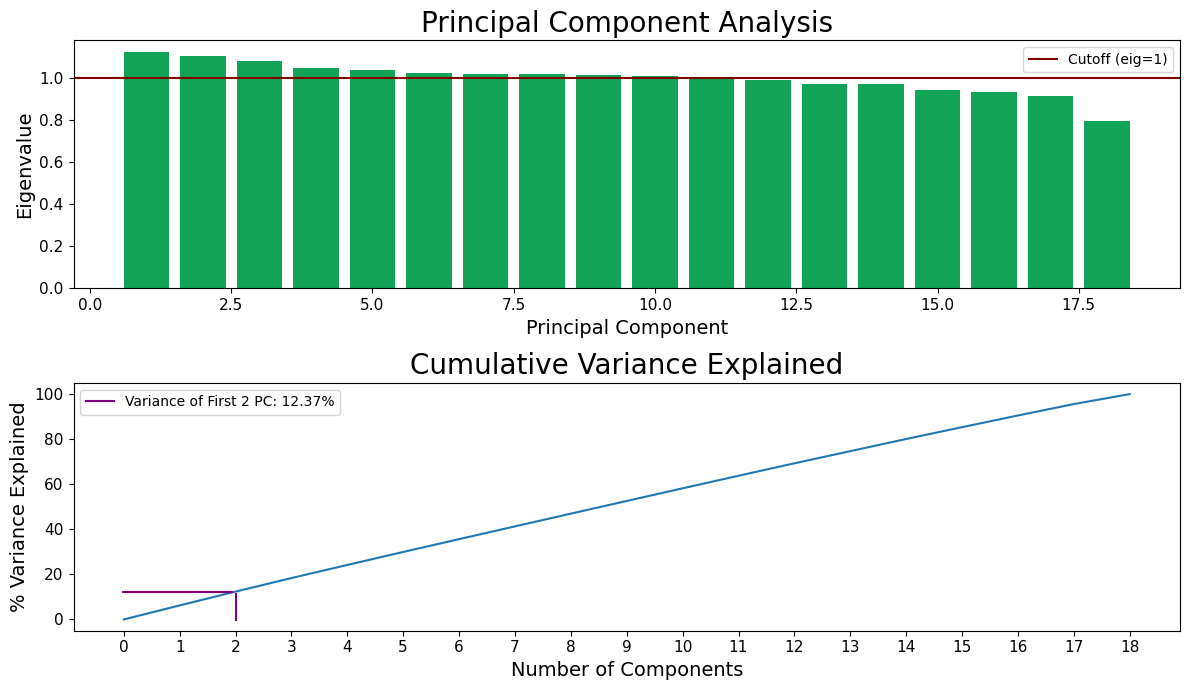

In [14]:
# define subplots
fig, (ax1, ax2) = plt.subplots(2,figsize=(12,7))

# PCA plot
ax1.bar(np.linspace(1, len(eig_values), len(eig_values)), eig_values, color = "#12a456")
ax1.axhline(y=1, color='maroon', label='Cutoff (eig=1)')
ax1.set_title('Principal Component Analysis', fontsize=20)
ax1.set_xlabel('Principal Component', fontsize=14)
ax1.set_ylabel('Eigenvalue', fontsize=14)
ax1.tick_params(axis="x", labelsize=11) 
ax1.tick_params(axis="y", labelsize=11)
ax1.legend()

# cumulative explained variance plot
ax2.plot(var1)
ax2.set_title('Cumulative Variance Explained', fontsize=20)
ax2.set_xlabel('Number of Components', fontsize=14)
ax2.set_ylabel('% Variance Explained', fontsize=14)
ax2.tick_params(axis="x", labelsize=11) 
ax2.tick_params(axis="y", labelsize=11)
ax2.axvline(x=2, color='purple', ymin=0.045, ymax=var1[2]/84)
ax2.axhline(y=var1[2], color='purple', xmin=.045, xmax=.143, label='Variance of First 2 PC: ' + str(var1[2]) + '%')
ax2.legend()
plt.sca(ax2)
plt.xticks(range(0,19))

# display
fig.tight_layout()
plt.show()

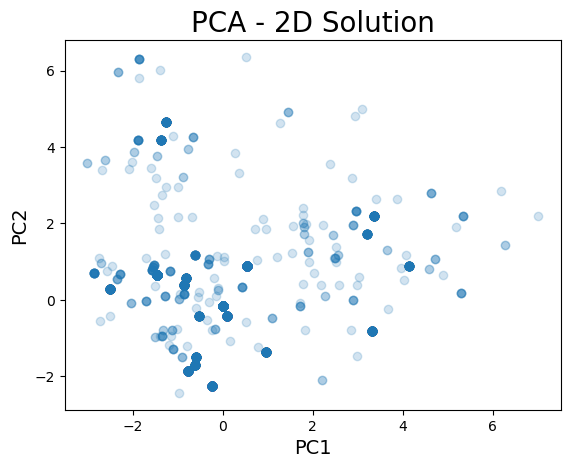

In [15]:
# 2d Solution

# z-score data
zscore_LQ = stats.zscore(X) # normalize data to have a mean of ~0 and a variance of 1
pca = PCA(n_components=2)
components = pca.fit_transform(zscore_LQ)
plt.title('PCA - 2D Solution', fontsize=20)
plt.scatter(components[:,0], components[:,1], alpha=0.2)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)
plt.show()

#### t-SNE

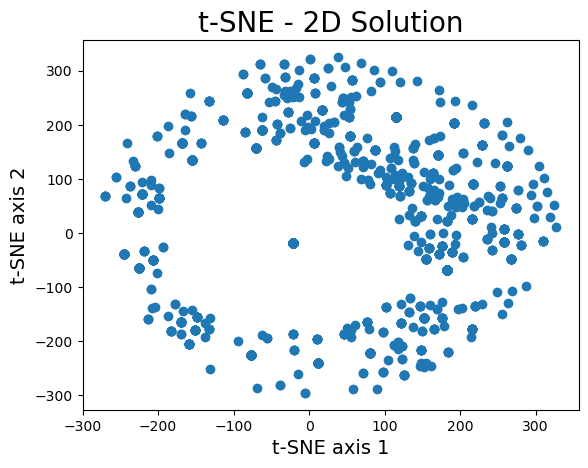

In [16]:
# t-SNE , 2d solution, 20 perplexity, random state 22
X_embedded = TSNE(n_components=2, perplexity=20, random_state=22).fit_transform(zscore_LQ)
plt.title('t-SNE - 2D Solution', fontsize=20)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.xlabel('t-SNE axis 1', fontsize=14)
plt.ylabel('t-SNE axis 2', fontsize=14)
plt.show()

Decision-making process for labeling.
- Use dbSCAN to verify clusters, but it's obvious
    - Here, displays positive tweets, 1 inside is neutral.
    - Clearly positive: features were good, great, true, etc...
- Drop 1 neutral/inconclusive record
- Label all other tweets as negative

### Clustering
Each cluster represents sentiment (positive, negative, neutral...?)
- dbSCAN: density based (this type of pattern)


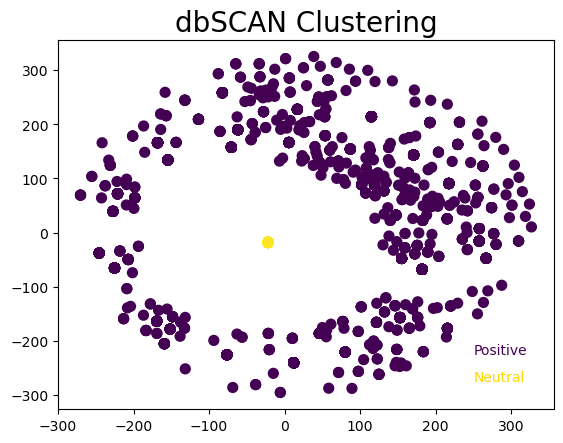

In [21]:
# dbSCAN
dbscan = DBSCAN(eps=100, min_samples=2).fit(X_embedded)
labels = dbscan.labels_
plt.title('dbSCAN Clustering', fontsize=20)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, s=50, cmap='viridis')
plt.annotate('Neutral', (250, -275), color='gold', fontsize=10)
plt.annotate('Positive', (250, -225), color='#440154', fontsize=10)
plt.show()


### Assign Labels
- Positive:
    - Contain features identified above (feature_names)
        - Maybe 3 of the 9
- Neutral
    - 1 Tweet in center
    - Just make negative
- Negative:
    - All other Tweets not containing those features

In [17]:
# Label each tweet based on t-SNE embedded results
# 1 = positive
# 0 = negative
sentiments=[]
for tweet in new_df['text']:
    for feature in feature_names:
        if feature in tweet:
            sentiments.append(1)
            break
    else:
        sentiments.append(0)
new_df['sentiment'] = np.array(sentiments)
new_df['sentiment'].value_counts()

0    2803
1    2352
Name: sentiment, dtype: int64

### Example Positive and Negative Tweets:


In [18]:
pos_ind = new_df.loc[new_df['sentiment']==1].index.values
neg_ind = new_df.loc[new_df['sentiment']==0].index.values

In [19]:
p_inds = [174,213,258]
n_inds = [514,551,1585]
print('Positive Tweets:')
for i, ind in enumerate(p_inds):
    print(i, ':', df['text'][ind])
print('\nNegative Tweets:')
for i, ind in enumerate(n_inds):
    print(i, ':', df['text'][ind])

Positive Tweets:
0 : @SawyerMerritt A picture is worth 1000 tweets
1 : @chicago_glenn We should thank farmers more
2 : Thank goodness for Senator Manchin

Negative Tweets:
0 : @TaraBull808 Sounds pretty bad
1 : @RBReich You both an idiot and a liar
2 : @stillgray Agreed, that is not ok


### Baseline Modeling (Classification)
- Train test split
- Modeling
    - LogisticRegression
    - SVM
    - Decision Tree
    - Random Forest Classifier
    - Sequential Dense Model

In [81]:
# Vectorize
# Combine all text into 1 corpus
corpus = [tweet for tweet in text]

# Vectorize text
vectorizer = TfidfVectorizer(min_df=60, stop_words='english')
vectors = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
#print('Features:', feature_names)

# Matrix
matrix = vectors.todense()
list_dense = matrix.tolist()
train_df = pd.DataFrame(list_dense, columns=feature_names)
train_df['sentiment'] = new_df['sentiment']

In [82]:
# Define X y
X = train_df.loc[:, train_df.columns != 'sentiment']
y = train_df['sentiment']
fpr = []
tpr = []
rocauc = []

In [101]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
                                                    

In [102]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
lrfpr, lrtpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
lr_acc = accuracy_score(y_test, lr_pred)
#lr_acc = lr.score(X_test, y_test)

In [103]:
# SVM
svm = LinearSVC(C = 1e-10, dual = False)
model = CalibratedClassifierCV(svm).fit(X_train, y_train)
svm_pred = model.predict(X_test)
svm_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
svmfpr, svmtpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
svm_acc = accuracy_score(y_test, svm_pred)
#svm_acc = model.score(X_test, y_test)


In [104]:
# Tree
tree = DecisionTreeClassifier().fit(X_train, y_train)
tree_pred = tree.predict(X_test)
tree_auc = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
treefpr, treetpr, thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:, 1])
tree_acc = accuracy_score(y_test, tree_pred)
#tree_acc = tree.score(X_test, y_test)

In [105]:
# Random Forest
rfc = RandomForestClassifier(criterion='gini').fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
rfc_auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])
rfcfpr, rfctpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:, 1])
rfc_acc = accuracy_score(y_test, rfc_pred)
#rfc_acc = rfc.score(X_test, y_test)

In [106]:
# Base Sequential
model = Sequential()
model.add(Dense(32, input_shape=(18,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, 
          epochs=5, 
          validation_data=(X_test, y_test))
base_nn_acc = max(model.history.history['val_accuracy'])

Epoch 1/5
113/113 [==============================] - 1s 4ms/step - loss: 0.6107 - accuracy: 0.8681 - val_loss: 0.5198 - val_accuracy: 0.8998
Epoch 2/5
113/113 [==============================] - 0s 2ms/step - loss: 0.4687 - accuracy: 0.8914 - val_loss: 0.4166 - val_accuracy: 0.8998
Epoch 3/5
113/113 [==============================] - 0s 3ms/step - loss: 0.4123 - accuracy: 0.8914 - val_loss: 0.3831 - val_accuracy: 0.8998
Epoch 4/5
113/113 [==============================] - 0s 2ms/step - loss: 0.3869 - accuracy: 0.8914 - val_loss: 0.3627 - val_accuracy: 0.8998
Epoch 5/5
113/113 [==============================] - 0s 3ms/step - loss: 0.3693 - accuracy: 0.8914 - val_loss: 0.3471 - val_accuracy: 0.8998


In [98]:
# CNN (LeNet)
# LeNet-5
# Input: standard
# Hidden: batch

lenet = Sequential()
# Input
lenet.add(Conv2D(filters=6, kernel_size=(3, 3), activation='tanh', input_shape=(18,)))
lenet.add(AveragePooling2D())
lenet.add(Normalization())

# Hidden layer 1
lenet.add(Conv2D(filters=16, kernel_size=(3, 3), activation='tanh'))
lenet.add(AveragePooling2D())
lenet.add(BatchNormalization())
lenet.add(Flatten())

# Hidden layer 2
lenet.add(Dense(units=128, activation='tanh'))
lenet.add(BatchNormalization())

# Output layer
lenet.add(Dense(units=2, activation = 'sigmoid'))

lenet.compile(optimizer='adam',
              loss='binary_categorical_crossentropy',
              metrics=['accuracy'])

lenet.fit(X_train, y_train, 
          epochs=5, 
          validation_data=(X_test, y_test))

ValueError: Input 0 of layer "conv2d_17" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 18)

### Model Performances (Accuracy)
- Accuracy works here due to nearly even balancing of classes
- Can focus on AUC, recall, precision going forward

In [126]:
print('Accuracy:')
print('Logisitc Regression:', np.round(lr_acc,4))
print('SVM:', np.round(svm_acc,4))
print('Decision Tree:', np.round(tree_acc,4))
print('Random Forest:', np.round(rfc_acca,4))
print('Base Dense NN:', np.round(base_nn_acc,4))

Accuracy:
Logisitc Regression: 0.9355
SVM: 0.5339
Decision Tree: 0.8102
Random Forest: 0.9558
Base Dense NN: 0.8998


### Hyperparameter Tune Best Model

In [254]:
# Extract Sentiment Values for each tweet 
def label_sentiment(x:float):
    if x < -0.05 : return 'negative'
    if x > 0.35 : return 'positive'
    return 'neutral'

sia = SIA()
new_df['sentiment'] = [sia.polarity_scores(x)['compound'] for x in tqdm(new_df['text'])]
new_df['overall_sentiment'] = new_df['sentiment'].apply(label_sentiment);





  0%|          | 0/5155 [00:00<?, ?it/s]

In [255]:
new_df

,text,datetime,sentiment,overall_sentiment
0,i find the gold toe sock inevitably off kilter...,2022-07-05 17:55:09,-0.5423,negative
1,sock con the conference for socks,2022-07-05 17:47:42,0.0000,neutral
2,always something new for the magazine cover an...,2022-07-05 17:46:15,0.0000,neutral
3,this guy gets it,2022-07-05 17:40:05,0.0000,neutral
4,sock tech is so advanced that you can get pret...,2022-07-05 17:38:23,0.7019,positive
...,...,...,...,...
5150,11 4 1 is promising,2023-04-30 16:54:01,0.4019,positive
5151,tesla self driving is by far the most advanced...,2023-04-30 16:16:42,0.3167,neutral
5152,it is becoming harder for people to get car lo...,2023-04-30 15:48:47,0.6705,positive
5153,cool,2023-04-30 15:29:12,0.3182,neutral
